<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 5: Practical - Recurrent Neural Networks <br>
<font color=696880 size=4>
    Alireza Farashah, Parsa Hosseini
    
    
____


### Full Name : Mohammad Bagher Soltani
### Student Number : 98105813
___

# Image Captioning using Recurrent Neural Networks
In this notebook we want to implement a deep neural network to caption Flickr images. It has 8091 images and each image in this dataset has an ID and there are 5 caption for each image in captions.txt file which is uploaded in Quera. We use pretrained ResNet50 model to get meaningful features from each image. Code of this part is implemented and you have to use id_to_feature and id_to_caption dictionary. See the code to understand what are these two dictionaries.
You have to implement the empty parts of this notebook.

# Import Libaries and Dataset

In [156]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [157]:
from google.colab import drive
drive.mount('/content/drive')

# %mkdir /content/drive/MyDrive/ML_HW4
%cd /content/drive/MyDrive/ML_HW4
#!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
#!unzip Flickr8k_Dataset.zip -d images/
#!unzip captions.txt.zip -d text/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ML_HW4


# Creeating Features and Captions Dcitionary

In [158]:
load_features = True

id_to_features = {}
if load_features:
  with open("id_to_features.pickle", 'rb') as f:
    id_to_features = pickle.load(f)
else:
  resnet50 = tf.keras.applications.ResNet50(
      include_top=False,
      weights="imagenet",
      pooling='avg'
  )

  for name in tqdm(os.listdir("images/Flicker8k_Dataset")):
      img = img_to_array(load_img("images/Flicker8k_Dataset/" + name, target_size=(224,224)))
      img = preprocess_input(img.reshape((1, img.shape[0], img.shape[1], img.shape[2])))
      feature = resnet50.predict(img, verbose=0)
      id_to_features[name.split('.')[0]]=feature
  
  with open("id_to_features.pickle", 'wb') as f:
    pickle.dump(id_to_features, f)


In [159]:
id_to_features['587604325_af5d6df679'].shape

(1, 2048)

In [160]:
len(id_to_features)

8091

In [161]:
from itertools import islice

id_to_captions = {}

load_captions = True

if load_captions:
  with open("id_to_captions.pickle", "rb") as f:
    id_to_captions = pickle.load(f)
else:
  with open("text/captions.txt", 'r') as f:
      for i, line in enumerate(f):
          if i==0:
              continue
          tokens = line.split('.jpg,')
          id, caption = tokens[0], tokens[1]
          if id not in id_to_captions:
              id_to_captions[id] = []
          id_to_captions[id].append(caption) 
  with open("id_to_captions.pickle", "wb") as f:
    pickle.dump(id_to_captions, f)

In [162]:
len(id_to_captions)

8091

In [163]:
id_to_captions['587604325_af5d6df679']

['A curly haired dog tries to bite another dog wearing a green and orange collar .\n',
 'One brown dog is bearing its teeth at another brown dog with a green collar in a park .\n',
 'Two brown dogs playing .\n',
 '"Two dogs , one with its mouth open ."\n',
 'Two golden dogs playing with one another\n']

In [164]:
#%rm -rf images text

# Preprocessing and Tokenizing (15 points)

In this part you need to clean the captions text in order to use Tokenizer.

In [165]:
# preprocess caption texts
tokenizer = Tokenizer()

def preprocessing(id_to_captions, tokenizer):
  texts = []
  for id, cap_list in id_to_captions.items():
    for i, cap in enumerate(cap_list):
      for old_value in ['\n', '.', ',', '"', '\ ', '\t']:
        cap = cap.replace(old_value, '')
      cap = cap.lower()
      cap = ' '.join(['startchar', cap, 'endchar'])
      id_to_captions[id][i] = cap
      texts.append(cap)

  tokenizer.fit_on_texts(texts)
  vocab_size = len(tokenizer.word_index) + 1
  seq_max = max([len(text.split()) for text in texts])
  return id_to_captions, tokenizer, vocab_size, seq_max

id_to_captions, tokenizer, VOCAB_SIZE, SEQUENCE_MAX = preprocessing(id_to_captions, tokenizer)


In [166]:
print(id_to_captions['587604325_af5d6df679'])
print(f'Sequence max length: {SEQUENCE_MAX}, Vocabulary size: {VOCAB_SIZE}')

['startchar a curly haired dog tries to bite another dog wearing a green and orange collar  endchar', 'startchar one brown dog is bearing its teeth at another brown dog with a green collar in a park  endchar', 'startchar two brown dogs playing  endchar', 'startchar two dogs  one with its mouth open  endchar', 'startchar two golden dogs playing with one another endchar']
Sequence max length: 38, Vocabulary size: 8492


## Data Generator (25 points)

In this part implement a data generator function to use during the training.
For each image and caption you have to create number of train samples in the following format.

caption: "start_char the man is playing football end_char"

sample 0: X="start_char", Y="the "

sample 1: X="start_char the", Y="man"

...

sample n: X="start_char the man is playing football", Y="end_char"

In [167]:
tokenizer.texts_to_sequences([id_to_captions['587604325_af5d6df679'][0]])

[[2, 1, 841, 249, 9, 407, 20, 937, 70, 9, 21, 1, 56, 8, 88, 256, 3]]

In [168]:
# craete data generator 
def data_generator(**kwargs):
    # insert your code here
    id_to_features = kwargs["id_to_features"]
    id_to_captions = kwargs["id_to_captions"]
    id_selection = kwargs["id_selection"]
    batch_size = kwargs["batch_size"]
    tokenizer = kwargs["tokenizer"]
    sequence_max = kwargs["sequence_max"]
    vocab_size = kwargs["vocab_size"]

    h, x, y = [], [], []

    while True:
      i = 0
      for id in id_selection:
        features = id_to_features[id][0]
        captions = id_to_captions[id]
        sequences = tokenizer.texts_to_sequences(captions)
        new_x = []
        new_y = []
        for seq in sequences:
          for j in range(1, len(seq)):
            new_x.append(seq[:j])
            new_y.append(seq[j])
        new_x = pad_sequences(new_x, maxlen=sequence_max)
        new_y = to_categorical(new_y, num_classes=vocab_size)
        h = h + [features] * len(new_x)
        x = x + list(new_x)
        y = y + list(new_y)
        
        i = i + 1
        if i == batch_size:
          yield [np.array(h), np.array(x)], np.array(y)
          h, x, y = [], [], []
          i = 0

In [169]:
np.random.seed(44)
train_ratio = 0.9
train_size = int(len(id_to_features) * 0.9)
all_ids = list(id_to_features.keys())
train_ids = list(np.random.choice(all_ids, train_size, replace=False))
test_ids = list(set(all_ids) - set(train_ids))

In [170]:
print(len(all_ids))
print(len(train_ids))
print(len(test_ids))

8091
7281
810


## Model (20 points)

In [171]:
# define the model
from tensorflow import keras
from keras.layers import Input, LSTM, Embedding, Dense, Dropout
from keras.models import Model

EMB_SIZE = 256
HIDDEN_SIZE = EMB_SIZE
FEATURE_SIZE = id_to_features[all_ids[0]].shape[1]

# encoder
hidden_inputs = Input(shape=FEATURE_SIZE)
hidden_reduced = Dense(HIDDEN_SIZE, activation='relu')(hidden_inputs)
sequence_inputs = Input(shape=SEQUENCE_MAX)
embedding = Embedding(VOCAB_SIZE, EMB_SIZE, mask_zero=True)(sequence_inputs)
lstm = LSTM(HIDDEN_SIZE)(embedding, initial_state=[hidden_reduced, hidden_reduced])

# decoder
decoder = Dense(HIDDEN_SIZE, activation='relu')(lstm)
outputs = Dense(VOCAB_SIZE, activation='softmax')(decoder)

# encoder-decoder
model = Model(inputs=[hidden_inputs, sequence_inputs], outputs=outputs)

batch_size = 32

  # id_to_features = kwargs["id_to_features"]
  # id_to_captions = kwargs["id_to_captions"]
  # id_selection = kwargs["id_selection"]
  # batch_size = kwargs["batch_size"]
  # tokenizer = kwargs["tokenizer"]
  # sequence_max = kwargs["sequence_max"]
  # vocab_size = kwargs["vocab_size"]

generator = data_generator(**{
    "id_to_features": id_to_features,
    "id_to_captions": id_to_captions,
    "id_selection": train_ids,
    "batch_size": batch_size,
    "tokenizer": tokenizer,
    "sequence_max": SEQUENCE_MAX,
    "vocab_size": VOCAB_SIZE
})

In [172]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 38)]         0           []                               
                                                                                                  
 input_20 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 embedding_9 (Embedding)        (None, 38, 256)      2173952     ['input_21[0][0]']               
                                                                                                  
 dense_27 (Dense)               (None, 256)          524544      ['input_20[0][0]']               
                                                                                            

# Train (10 points)

Train the model and plot loss for training data.

In [173]:
# train the model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

num_epochs = 10
steps_per_epoch = len(train_ids) // batch_size

optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

model_path = 'model'
checkpoint = ModelCheckpoint(model_path, monitor='loss', verbose=1, save_best_only=True)

load_model = False
if load_model:
  model = tf.keras.models.load_model(model_path)
else:
  model.fit(generator, epochs=num_epochs, steps_per_epoch=steps_per_epoch, callbacks=[checkpoint])
  model.save(model_path)


Epoch 1/10
227/227 [==============================] - ETA: 0s - loss: 4.9959
Epoch 1: loss improved from inf to 4.99595, saving model to model


227/227 [==============================] - 67s 258ms/step - loss: 4.9959
Epoch 2/10
227/227 [==============================] - ETA: 0s - loss: 3.8808
Epoch 2: loss improved from 4.99595 to 3.88085, saving model to model


227/227 [==============================] - 60s 265ms/step - loss: 3.8808
Epoch 3/10
227/227 [==============================] - ETA: 0s - loss: 3.5313
Epoch 3: loss improved from 3.88085 to 3.53129, saving model to model


227/227 [==============================] - 59s 260ms/step - loss: 3.5313
Epoch 4/10
227/227 [==============================] - ETA: 0s - loss: 3.3167
Epoch 4: loss improved from 3.53129 to 3.31671, saving model to model


227/227 [==============================] - 57s 251ms/step - loss: 3.3167
Epoch 5/10
227/227 [==============================] - ETA: 0s - loss: 3.1488
Epoch 5: loss improved from 3.31671 to 3.14883, saving model to model


227/227 [==============================] - 82s 360ms/step - loss: 3.1488
Epoch 6/10
227/227 [==============================] - ETA: 0s - loss: 3.0086
Epoch 6: loss improved from 3.14883 to 3.00862, saving model to model


227/227 [==============================] - 87s 383ms/step - loss: 3.0086
Epoch 7/10
227/227 [==============================] - ETA: 0s - loss: 2.8879
Epoch 7: loss improved from 3.00862 to 2.88792, saving model to model


227/227 [==============================] - 90s 396ms/step - loss: 2.8879
Epoch 8/10
227/227 [==============================] - ETA: 0s - loss: 2.7829
Epoch 8: loss improved from 2.88792 to 2.78294, saving model to model


227/227 [==============================] - 78s 343ms/step - loss: 2.7829
Epoch 9/10
227/227 [==============================] - ETA: 0s - loss: 2.6924
Epoch 9: loss improved from 2.78294 to 2.69235, saving model to model


227/227 [==============================] - 93s 408ms/step - loss: 2.6924
Epoch 10/10
227/227 [==============================] - ETA: 0s - loss: 2.6111
Epoch 10: loss improved from 2.69235 to 2.61114, saving model to model


227/227 [==============================] - 89s 392ms/step - loss: 2.6111


## Test (30)

In this part evaluate the model and generate caption for 10 of test images. For evaluation use "bert-base-uncased" pretrained model and calculate similarity for the predicted sentence of model and real captions. 
Show 3 of the images and predictied samples.

In [174]:
# !pip install transformers

In [183]:
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity

bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased",)
bert_model = AutoModel.from_pretrained("bert-base-uncased",output_hidden_states=True)


def get_embeddings(text,token_length):
    tokenized=bert_tokenizer(text,max_length=token_length,padding='max_length',truncation=True)
    input_ids = torch.tensor(tokenized.input_ids).unsqueeze(0)
    attention_mask = torch.tensor(tokenized.attention_mask).unsqueeze(0)
    output=bert_model(input_ids, attention_mask=attention_mask).hidden_states[-1]
    return torch.mean(output,axis=1).detach().numpy()

def calculate_similarity(text1,text2,token_length=20):
  text1 = get_embeddings(text1,token_length)
  text2 = get_embeddings(text2,token_length)
  return cosine_similarity(text1.reshape(1,-1),text2.reshape(1,-1))[0][0]


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


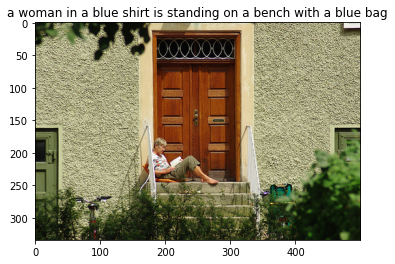

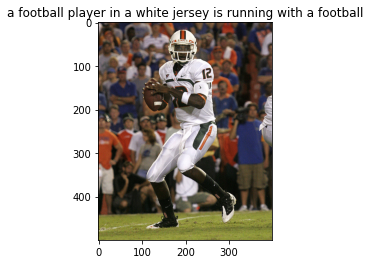

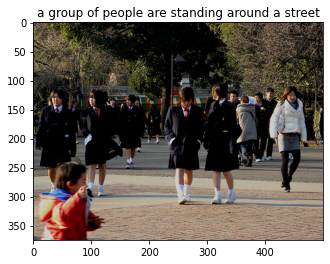

In [179]:
import matplotlib.pyplot as plt

def generate_caption(features):
  x = 'startchar'
  for i in range(SEQUENCE_MAX):
    seq = tokenizer.texts_to_sequences([x])[0]
    padded = pad_sequences([seq], maxlen=SEQUENCE_MAX)
    output = model.predict([features,padded], verbose=0)
    pred = np.argmax(output)
    word = tokenizer.index_word[pred]
    x = ' '.join([x, word])
    if word == 'endchar':
      break
  caption = ''
  x_split = x.split()
  if x_split[-1] == 'endchar':
    caption = ' '.join(x_split[1:-1])
  else:
    caption = ' '.join(x_split[1:])
  return caption

img_path = 'images/Flicker8k_Dataset'
for i in range(3):
  sample_id = test_ids[i]
  sample_path = os.path.join(img_path , sample_id + '.jpg')
  sample_img = plt.imread(sample_path)
  sample_features = id_to_features[sample_id]
  sample_caption = generate_caption(sample_features)
  plt.imshow(sample_img)
  plt.title(sample_caption)
  plt.show()


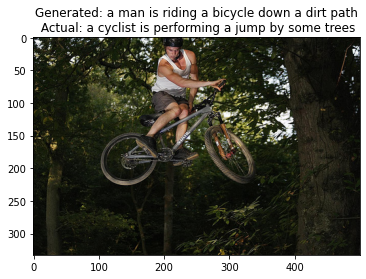

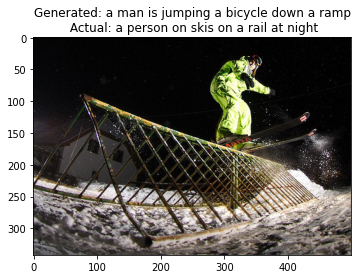

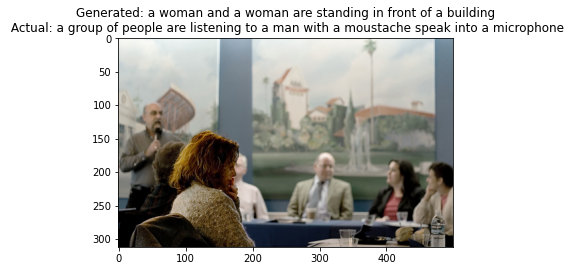

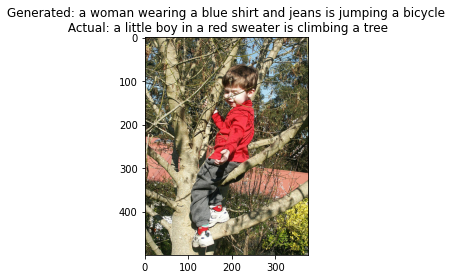

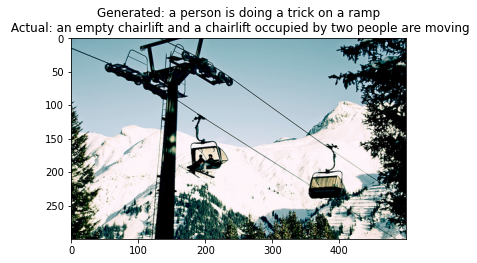

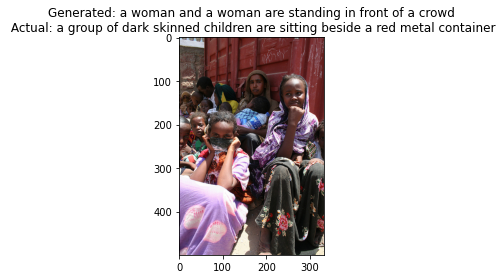

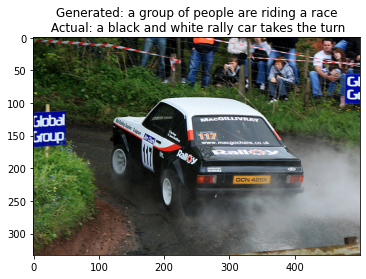

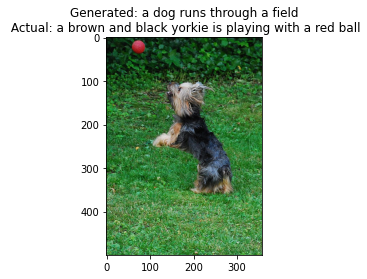

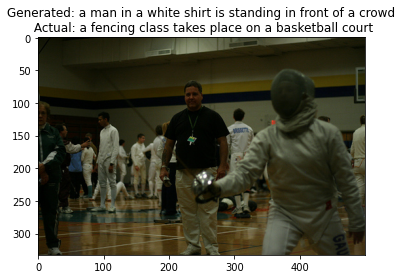

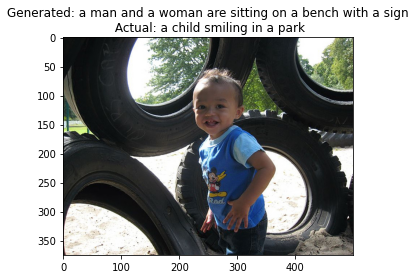

Similarity Score: 0.83


In [184]:
def postprocess(id):
  caption = id_to_captions[id][0]
  return caption.replace('startchar', '').replace('endchar', '').strip()

sample_ids = np.random.choice(test_ids, 10, replace=False)
actual_captions = list(map(postprocess, sample_ids))
similarity = 0.0

for i in range(10):
  sample_id = sample_ids[i]
  sample_features = id_to_features[sample_id]
  generated_caption = generate_caption(sample_features)
  actual_caption = actual_captions[i]
  similarity += calculate_similarity(generated_caption, actual_caption, token_length = SEQUENCE_MAX)
  title = f'Generated: {generated_caption}\n Actual: {actual_caption}'
  sample_img = plt.imread(os.path.join(img_path, sample_id + '.jpg'))
  plt.imshow(sample_img)
  plt.title(title)
  plt.show()

print(f'Similarity Score: {similarity / 10:.2f}')
